# Parameter
머신러닝/딥러닝에는 2 종류의 파라미터가 있다. 이 2 종류의 파라미터를 통해서 학습을 진행한다.

- Model Parameters
> 모델 학습을 통해서 최종적으로 찾게되는 파라미터. 즉, 학습을 하면서 모델이 계속적으로 파라미터 값을 변경하게 된다.     
> 예) weights in Linear Regression
- Hyper Parameters
> 모델 학습을 효율적으로 할 수 있게 사전에 정의하는 파라미터.  
> 예) learning rate in LGBMClassifier

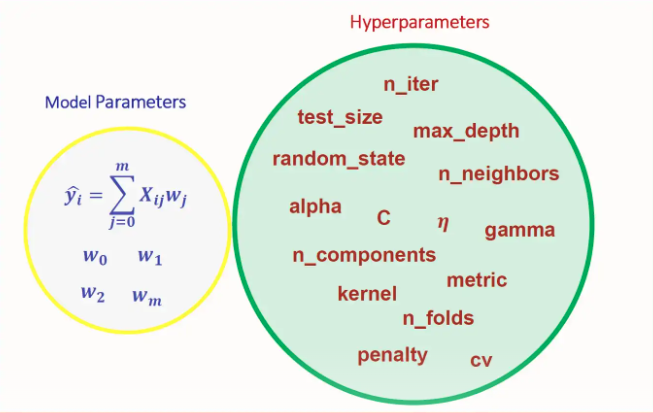

## [HPO(Hyper Parameter Optimization)](https://dacon.io/codeshare/4863)
하이퍼 파라미터는 최적의 학습 모델을 구현하기 위해 사용자가 지정해주는 값
- learning rate, max_depth, n_estimators 등 모델별 다양한 변들을이 하이퍼 파라미터에 해당
- 설정한 하이퍼 파라미터 값에 따라 모델의 성능이 달라지기 때문에 파라미터 값을 조정하여 최적의 조합을 찾는 것이 매우 중요

![](https://miro.medium.com/max/1400/1*UMtPi1QBHpfE4iF_egJ8sQ.gif)

# [HPO 탐색 방법](https://github.com/hyeonsangjeon/Hyperparameters-Optimization)
HPO를 최적화를 위해서 결정되어야 하는 것은 두 가지입니다.
- 하이퍼 파라미터 탐색 범위
- 하이퍼 파라미터 탐색 정책(방법)

라이브러리 임포트

In [ ]:
#!pip install lightgbm
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score

%matplotlib inline

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

데이터 로드

In [ ]:
import seaborn as sns

df = sns.load_dataset('titanic') # 타이타닉 데이터 받아오기
cols = ["age","sibsp","parch","fare"] # 숫자니까 바로 사용
features = df[cols] # 피쳐
target = df["survived"] # 정답값

데이터 인코딩

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cols = ["pclass","sex","embarked"] # 범주형

enc = OneHotEncoder(handle_unknown='ignore')
tmp = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

features = pd.concat([features,tmp],axis=1)

결측치 제거

In [ ]:
features.age = features.age.fillna(features.age.median())

데이터 스케일링

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

데이터 분리

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

random_state=42

X_tr, X_te, y_tr, y_te = train_test_split(
    features, target, test_size=0.20,
    shuffle=True, random_state=random_state)

X_tr.shape, X_te.shape

((712, 13), (179, 13))

검증

In [ ]:
n_iter=50
num_folds=2 # 학습시간을 줄이기 위해 2로 하였다. 일반적으로는 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

In [ ]:
def print_scores(y_te,pred):
  print(confusion_matrix(y_te, pred))
  print('-'*50)
  print(classification_report(y_te, pred))

LGBMClassifier Hyper Parameter

- 주요 파리미터
  - n_estimators : 모델에서 사용할 트리 갯수(학습시 생성할 트리 갯수)
  - learning_rate : 학습률
  - criterion : 분할 품질을 측정하는 기능 (default : gini)
  - max_depth : 트리의 최대 깊이
  - min_samples_split : 내부 노드를 분할하는데 필요한 최소 샘플 수 (default : 2)
  - min_samples_leaf : 리프 노드에 있어야 할 최소 샘플 수 (default : 1)
  - min_weight_fraction_leaf : min_sample_leaf와 같지만 가중치가 부여된 샘플 수에서의 비율
  - max_features : 각 노드에서 분할에 사용할 특징의 최대 수
  - max_leaf_nodes : 리프 노드의 최대수
  - min_impurity_decrease : 최소 불순도
  - min_impurity_split : 나무 성장을 멈추기 위한 임계치
  - bootstrap : 부트스트랩(중복허용 샘플링) 사용 여부

In [ ]:
from lightgbm.sklearn import LGBMClassifier

## Manual Search
> 사람이 수동으로 하이퍼파라미터를 변경하는 작업

In [ ]:
hp = {
    "max_depth": 5,
    "criterion" : "gini",
    "n_estimators" : 50,
    "learning_rate" : 0.1
}

model = LGBMClassifier(**hp, random_state=random_state).fit(X_tr,y_tr)

[LightGBM] [Warning] Unknown parameter: criterion


In [ ]:
pred = model.predict(X_te)
print_scores(y_te, pred)

[[93 12]
 [21 53]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.72      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



In [ ]:
hp = {
    "max_depth": 4,
    "criterion" : "entropy",
    "n_estimators" : 150,
    "learning_rate" : 0.01
}

model = LGBMClassifier(**hp, random_state=random_state).fit(X_tr,y_tr)
pred = model.predict(X_te)
print_scores(y_te, pred)

[LightGBM] [Warning] Unknown parameter: criterion
[[93 12]
 [24 50]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       105
           1       0.81      0.68      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



## Grid Search
- 특정 하이퍼 파라미터 구간에서 일정 간격으로 값을 선택하여, 선택된 모든 값을 탐색하는 최적해를 찾는 가장 기본적이고 간단한 HPO 기법
- 구간 전역을 탐색하기 때문에 탐색 시간이 오래 걸리고, 균일한 간격으로 탐색하기 때문에 최적해를 찾지 못하는 경우가 발생할 수 있음

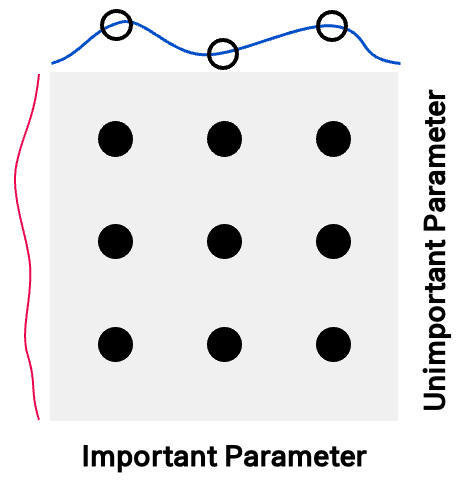

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "criterion" : ["gini","entropy"], # 순수도 척도
    "n_estimators" : np.linspace(800,1200,5, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}
model = LGBMClassifier(random_state=random_state)

gs=GridSearchCV(model, hp, scoring='roc_auc', n_jobs=-1, cv=kf, verbose=False).fit(X_tr,y_tr)

[LightGBM] [Warning] Unknown parameter: criterion


In [ ]:
gs.best_params_

{'criterion': 'gini',
 'learning_rate': 0.001,
 'max_depth': 6,
 'n_estimators': 1100}

In [ ]:
gs.best_score_

0.8389356255214173

In [ ]:
gs.score(X_te,y_te)

0.8875160875160876

In [ ]:
pred = gs.predict_proba(X_te)[:,1]
roc_auc_score(y_te,pred)

0.8875160875160876

In [ ]:
pred = gs.best_estimator_.predict(X_te)
print_scores(y_te, pred)

[[94 11]
 [26 48]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       105
           1       0.81      0.65      0.72        74

    accuracy                           0.79       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.79      0.79       179



<Axes: xlabel='param_criterion', ylabel='param_n_estimators'>

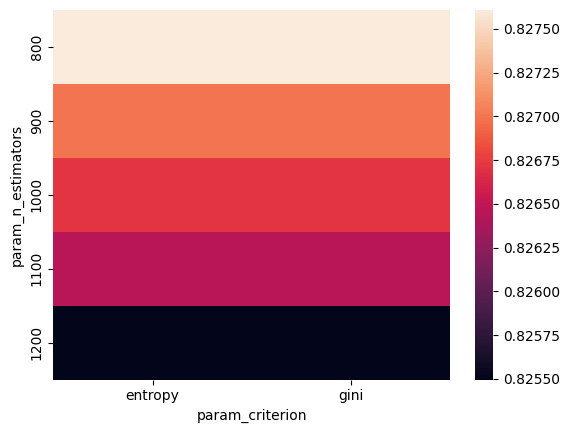

In [ ]:
table = pd.pivot_table(pd.DataFrame(gs.cv_results_),
    values='mean_test_score', index='param_n_estimators',
                       columns='param_criterion')

sns.heatmap(table)

상기 그래프를 통해 criterion의 종류는 성능에 영향을 주지 않는 다는 것을 알 수 있다.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

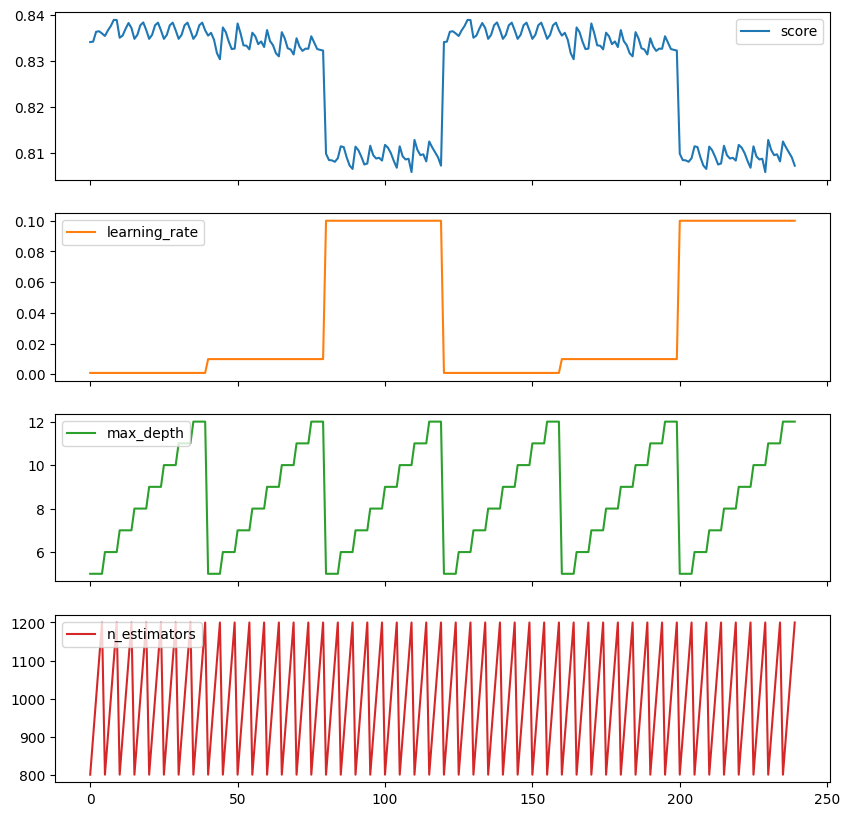

In [ ]:
gs_results_df=pd.DataFrame(np.transpose([gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_learning_rate'].data,
                                         gs.cv_results_['param_max_depth'].data,
                                         gs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

상기 그래프를 통해 learning_rate가 다른 하이퍼 파라미터보다 성능에 영향을 많이 준다는 것을 알 수 있다.

## Random Search
- 탐색 구간 안에서 임의로 파라미터 값을 선택
- 그리드 서치의 문제점을 보완하기 위해 고안된 기법
- 구간 내 랜덤 조합을 사용하기 때문에 더 많은 지점을 살펴볼 수 있고, 불필요한 반복 탐색이 줄어 그리드 서치보다 탐색 속도가 빠름

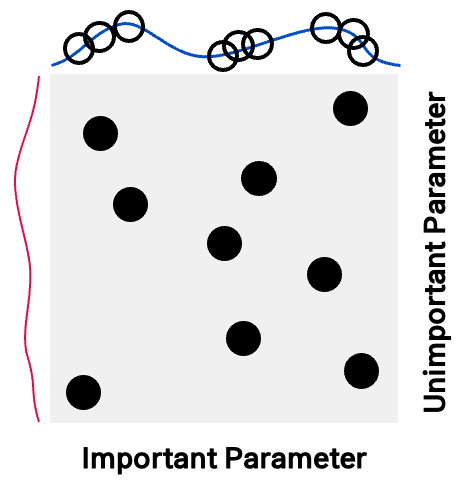

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "criterion" : ["gini","entropy"], # 순수도 척도
    "n_estimators" : np.linspace(800,1200,5, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}
model = LGBMClassifier(random_state=random_state)

rs=RandomizedSearchCV(model, hp, scoring='roc_auc', n_iter=n_iter, n_jobs=-1, cv=kf, verbose=False).fit(X_tr,y_tr)
rs.best_score_, rs.score(X_te,y_te)

[LightGBM] [Warning] Unknown parameter: criterion


(0.8389356255214173, 0.8875160875160876)

In [ ]:
pred = rs.predict_proba(X_te)[:,1]
roc_auc_score(y_te,pred)

0.8875160875160876

In [ ]:
pred = rs.best_estimator_.predict(X_te)
print_scores(y_te, pred)

[[94 11]
 [26 48]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       105
           1       0.81      0.65      0.72        74

    accuracy                           0.79       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.79      0.79       179



<Axes: xlabel='param_criterion', ylabel='param_n_estimators'>

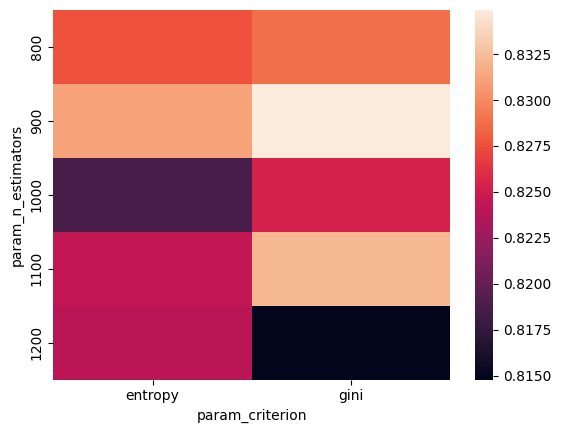

In [ ]:
table = pd.pivot_table(pd.DataFrame(rs.cv_results_),
    values='mean_test_score', index='param_n_estimators',
                       columns='param_criterion')

sns.heatmap(table)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

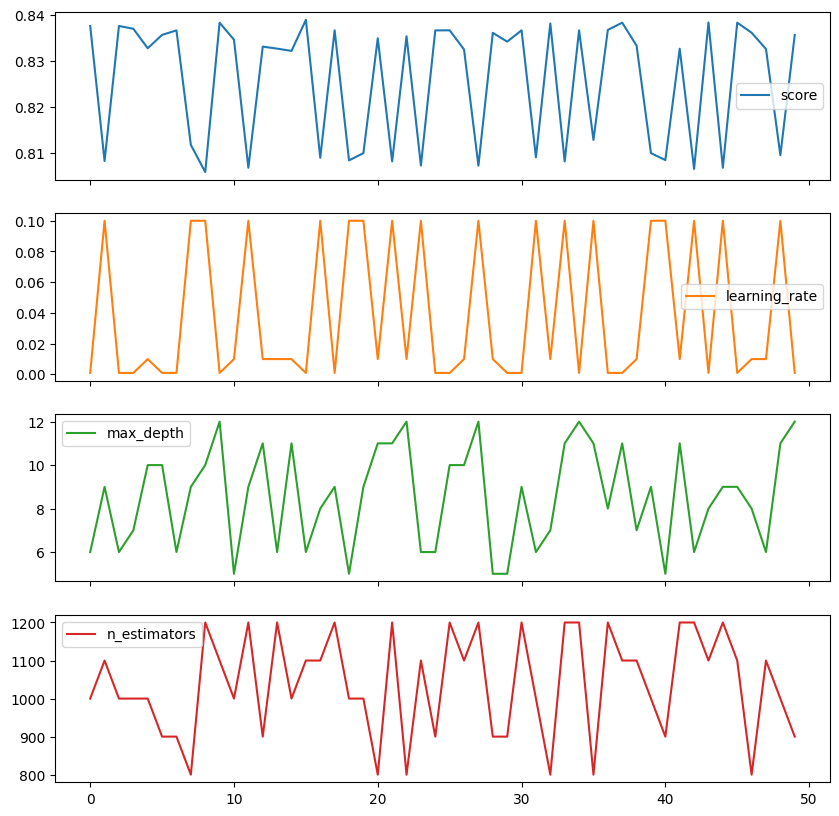

In [ ]:
rs_results_df=pd.DataFrame(np.transpose([rs.cv_results_['mean_test_score'],
                                         rs.cv_results_['param_learning_rate'].data,
                                         rs.cv_results_['param_max_depth'].data,
                                         rs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

Text(0, 0.5, 'best_cumulative_score')

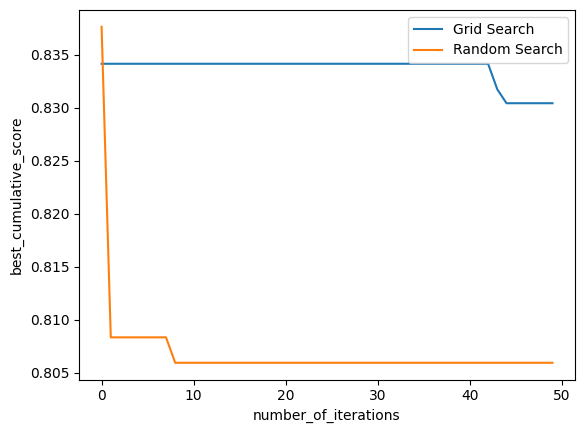

In [ ]:
scores_df=pd.DataFrame(index=range(n_iter))
scores_df['Grid Search']=gs_results_df['score'].cummin()
scores_df['Random Search']=rs_results_df['score'].cummin()

ax = scores_df.plot()
ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")

위의 그래프를 보면 Grid Search보다 Random Search가 더 빠르게 학습이 진행되는 것을 알 수 있다.

## Bayesian Search
- 매회 새로운 하이퍼파라미터값에 대한 조사를 수행할 시 사전 지식을 충분히 반영하면서 동시에 전체적인 탐색 과정을 체계적으로 수행할수 있는 방법
- 대체모델이라는걸 이용해서 이전 하이퍼파라미터조합의 적용결과를 기반으로 더 높은 성능점수를 얻는 하이퍼파라미터 조합을 예측하는 방식

![](https://github.com/hyeonsangjeon/Hyperparameters-Optimization/raw/master/pic/BayesianOpt.gif?raw=true)

### 일반적 Search 단점
> Manual Search, Grid Search, Random search 등은 각 파라미터들를 놀릴 뿐이지, 최적의 파라미터를 찾아주지는 못한다.  
> 이런 단점들을 해결하기 위해서 나온 방법론이 Bayesian Optimization이다.

아래는 왜 다른 방법들은 최적의 파라미터를 찾기 힘든지를 나타내준다.

![](https://blog.kakaocdn.net/dn/CI1D9/btqBs0kusd9/k7K6n7H75Yo9mZsll2IKO0/img.gif){: width="50%" height="50%"}{: .center}

### [optuna 라이브러리](https://optuna.readthedocs.io/en/stable/)

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.4 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

### [TPESampler](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html)

In [ ]:
from optuna.samplers import TPESampler
optuna.logging.disable_default_handler()

목적 함수

In [ ]:
class Objective:
    def __init__(self,x_train,y_train,seed):
        self.x_train = x_train
        self.y_train = y_train
        self.seed = seed
        num_folds=2 # 학습시간을 줄이기 위해 2로 하였다. 일반적으로는 5
        self.cv = KFold(n_splits=num_folds,shuffle=True,random_state=self.seed)
    def __call__(self,trial):
        hp = {
            "max_depth" : trial.suggest_int("max_depth",2,5),
            "min_samples_split" : trial.suggest_int("min_samples_split",2,5),
            "criterion" : trial.suggest_categorical("criterion",["gini","entropy"]),
            "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes",5,10),
            "n_estimators" : trial.suggest_int("n_estimators",10,500,50),
            "learning_rate" : trial.suggest_float("learning_rate",0.01,0.1)
        }
        model = LGBMClassifier(random_state=self.seed,**hp)
        scores = cross_val_score(model,self.x_train,self.y_train, cv = self.cv , scoring="roc_auc")
        return np.mean(scores)

학습

In [ ]:
sampler = TPESampler(seed=random_state) # 대체모델 부분

# 스터디 객체
study = optuna.create_study(
    direction = "maximize", # maximize or minimize
    sampler = sampler
)
objective = Objective(X_tr,y_tr,random_state)
study.optimize(objective,n_trials=50)

print("Best Score:", study.best_value) # 최고점수
print("Best hp", study.best_params) # 최고점수의 하이퍼파라미터조합

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=5 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=5 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=10 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=10 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is

In [ ]:
model = LGBMClassifier(random_state=random_state, **study.best_params)
model.fit(X_tr,y_tr)

pred = model.predict_proba(X_te)[:,1]
roc_auc_score(y_te,pred)

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=7 will be ignored. Current value: num_leaves=31


0.8993564993564994

아래는 하이퍼파라미터 중요도이다.

In [ ]:
optuna.visualization.plot_param_importances(study)

아래는 하이퍼파라미터 학습과정에 대한 그래프이다.

In [ ]:
optuna.visualization.plot_optimization_history(study)